## Signal-To-Noise-Ratio


In [1]:
from kafka import KafkaProducer
import time
import datetime
import json
import numpy as np
import random
from utils.kafka_sender import set_sensor_delay
from utils.kafka_sender import plot_sens_obs, plot_drift_stream
from schemas.schema_sensor import SensorParams, DriftParams

In [2]:
NOISE_LEVEL=0  # Set NOISE LEVEL

params_sens1 = SensorParams(sensor_name="sensor-1",
                            mu=2,
                            sigma=3,
                            eps=NOISE_LEVEL,
                            delay_mode="fix",
                            delay_value=.1,
                            )

params_sens2 = SensorParams(sensor_name="sensor-2",
                            mu=3,
                            sigma=3,
                            eps=NOISE_LEVEL,
                            delay_mode="fix",
                            delay_value=.1,
                            )

params_sens3 = SensorParams(sensor_name="sensor-3",
                            mu=1,
                            sigma=3,
                            eps=NOISE_LEVEL,
                            delay_mode="fix",
                            delay_value=.1,
                            )

In [3]:
producer = KafkaProducer(bootstrap_servers='localhost:9092', 
                         value_serializer=lambda v: json.dumps(v).encode('utf-8'))

## Desired signal

In [4]:
from utils.kafka_sender import stream_data

NUM_OBS = 100

list_signal_obs_1=[]
list_signal_obs_2=[]
list_signal_obs_3=[]

unbounded_data = stream_data(producer, params_sens1, params_sens2, params_sens3)

for _ in range(NUM_OBS):
    
    data = next(unbounded_data)
    
    list_signal_obs_1.append(data["sensor_1"]["obs"])
    list_signal_obs_2.append(data["sensor_2"]["obs"])
    list_signal_obs_3.append(data["sensor_3"]["obs"])

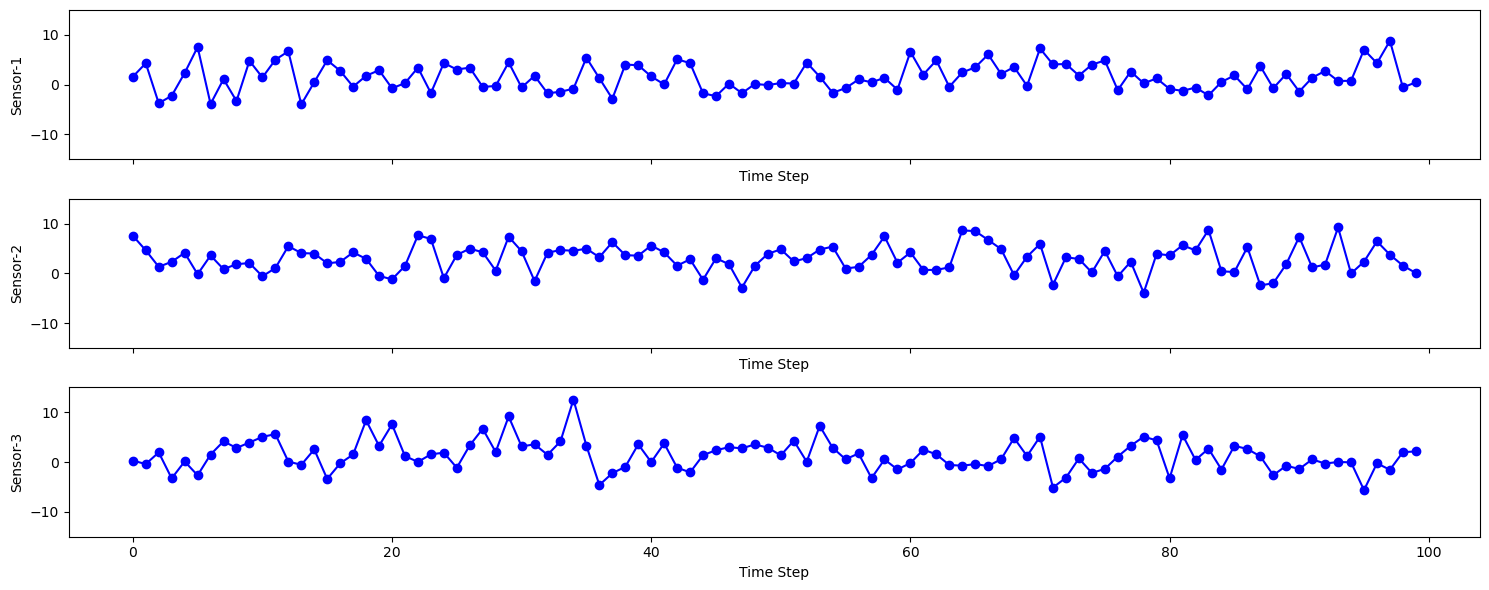

In [5]:
from utils.kafka_sender import plot_sens_obs

obs_data_stream = np.array([list_signal_obs_1, list_signal_obs_2, list_signal_obs_3])

# plot sensor observations
y_upper_limit= 15
y_lower_limit= -15
plot_sens_obs(obs_data_stream, ylim_low=y_lower_limit, ylim_up=y_upper_limit)

## Desired signal with background noise

In [6]:
# Add background noise
NOISE_LEVEL=5

params_sens1.eps = NOISE_LEVEL
params_sens2.eps = NOISE_LEVEL
params_sens3.eps = NOISE_LEVEL

In [7]:
list_noisy_obs_1=[]
list_noisy_obs_2=[]
list_noisy_obs_3=[]

unbounded_noisy_data = stream_data(producer, params_sens1, params_sens2, params_sens3)

for _ in range(NUM_OBS):
    
    noisy_data = next(unbounded_noisy_data)
    
    list_noisy_obs_1.append(noisy_data["sensor_1"]["obs"])
    list_noisy_obs_2.append(noisy_data["sensor_2"]["obs"])
    list_noisy_obs_3.append(noisy_data["sensor_3"]["obs"])

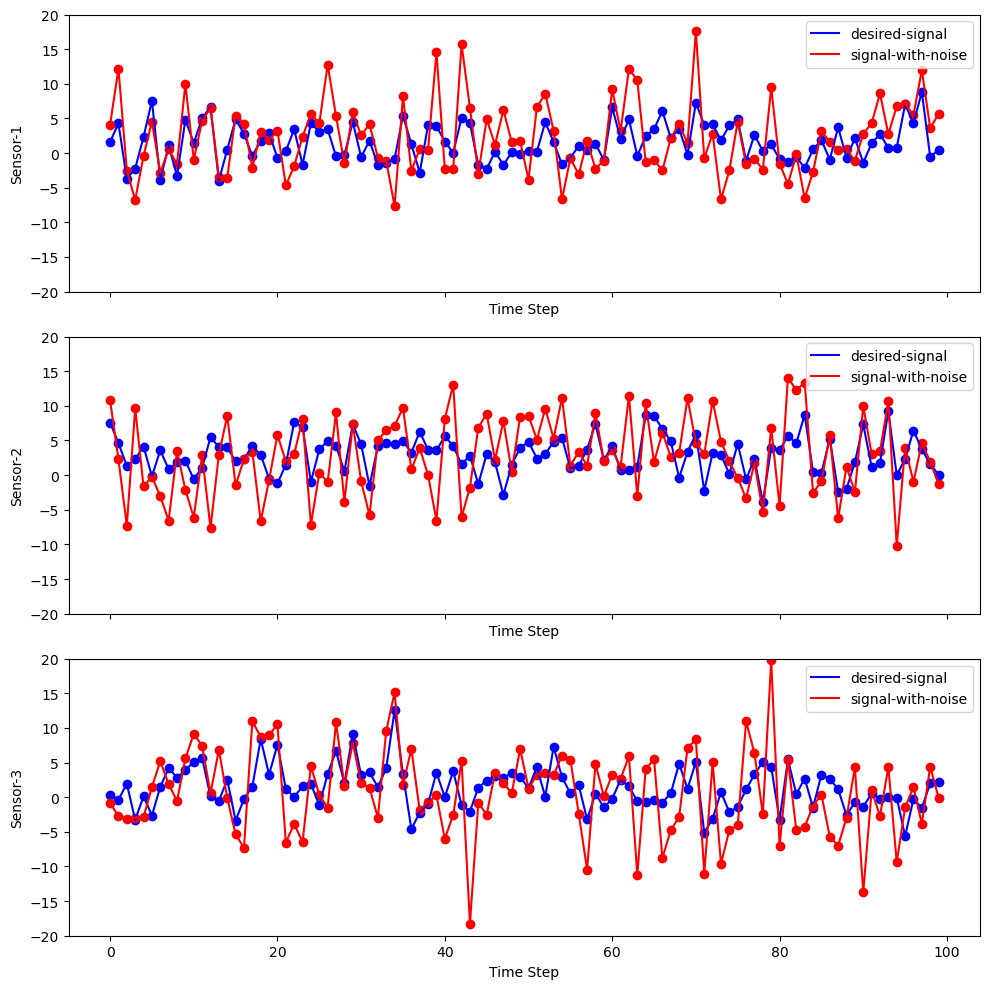

In [13]:
import matplotlib.pyplot as plt

noisy_obs_data_stream = np.array([list_noisy_obs_1, list_noisy_obs_2, list_noisy_obs_3])

noise_levels = {"signal": obs_data_stream,
                f"noise-level{NOISE_LEVEL}": noisy_obs_data_stream}

fig, axes = plt.subplots(nrows=len(obs_data_stream), ncols=1, figsize=(10, 10), sharex=True)
for idx, ax in enumerate(axes):
    ax.plot(np.arange(len(obs_data_stream[idx])), noise_levels["signal"][idx], color="blue", label="desired-signal")
    ax.scatter(np.arange(len(obs_data_stream[idx])), noise_levels["signal"][idx], color="blue")
    ax.plot(np.arange(len(obs_data_stream[idx])), noise_levels[f"noise-level{NOISE_LEVEL}"][idx], color="red", label="signal-with-noise")
    ax.scatter(np.arange(len(obs_data_stream[idx])), noise_levels[f"noise-level{NOISE_LEVEL}"][idx], color="red")
    ax.set_ylabel(f"Sensor-{idx + 1}")
    ax.set_xlabel("Time Step")
    ax.set_ylim(-20, 20)
    ax.legend()
plt.tight_layout()
plt.show()